# Introduction

In this notebook, you will learn how to construct a classification algorithm for determining whether a device is operating on textile carpet or hard floor. The information of the surface type can be used in various applications, such as manual and robotic vacuum cleaners for adjusting the operation of the unit for optimal performance.

Follow along the steps outline below, detailing data collection, model definition, training and evaluation. Once the model is ready, you will be able to run it on your computer and classify surfaces in realtime. 

If you want to learn more about Acconeer's sensors, algorithms and more, please visit the documentation and developer site, found [here](https://docs.acconeer.com/en/latest/index.html).

# Test setup

The required hardware for this example is
* XE121 - A121 evaluation kit. 
* XS121 - A121 satellite senors.
* Raspberry Pi.
* A powerbank.
* The intended device of operation.

The hardware from Acconeer can be bought at a number of online vendors such as [Digikey](https://www.digikey.com/) or [Mouser](https://www.mouser.se/c/unclassified/acconeer-ab/?q=acconeer).

To get your EVK up and running with the satellite sensor and Raspberry, visit our documentation and developer site, found [here](https://docs.acconeer.com/en/latest/index.html).

We will use a Kobuki as our device in this example. 
Kobuki is an all purpose robotic device, used for rapid prototyping.
For more information about Kobuki, follow this [link](http://kobuki.yujinrobot.com/about2/). 

The following picture gives an overview of the setup. 
* The XS121 is mounted at the front of the Kobuki using a 3D-printed sensor holder. If you don't have access to a 3D-printer, some cardboard and tape would work just fine.
* The sensor holder is angled at 40 deg relative to the normal of the floor. 
* The flex cable connects the sensor to the EVK board.
* The XE121 is connected to a Raspberry Pi, running the Acconeer's exploration server.
* The Raspberry Pi is powered by a power bank.

![Setup](doc/setup.png)

The purpose of tilting the angle of the sensor is to get sufficient energy back from both the floor directly under the sensor, but also from areas in front of the sensor.
The reason why this is necessary will become apparent when the features of the classification algorithm are discussed in a coming section.
For more information about the beam pattern and HPBW(Half Power Beam Width), see the documentation site.

To run this example, you also need to install Acconeer's Exploration Tool. 
The GUI part of the tool will be used during data collection. Several functions from the package are used in this example for loading and processing the data.
We encourage you to play around with the different examples and applications in the Exploration Tool to get familiar with the sensor.

For more information on how to install Exploration Tool and get started with your hardware, see the documentation site.

# Surface types
Three different hard floors and three carpets were used in this example.

The following picture shows the different surface types

![Surface types](doc\surface_types.png)

The characteristics of the surface is as follows(from left to right):
* Large tiles.
* Wood floor.
* Plastic/lenolium floor.
* Low fiber density carpet.
* High fiber density carpet.
* Thin carpet.

Once you have completed this example, we encourage you to record your own data from available surfaces.

# Features

The following two features will be extracted from the radar data and used when classifying the surface. The calculations are implemented in the included module *utils.py* in the functions *estimate_distance* and *calculate_variance_at_fixed_distance*.

### #1 - Distance to floor

The concept behind this feature is that when the device is running directly on a hard floor, the estimated distance will be close to the nominal height at which the sensor has been installed, relative to the floor. 
Next, when the device moves onto a textile carpet, the underlying carpet will contribute to an increased distance between the sensor and the floor. 
As textile carpets typically are relative transparent, the majority of the reflected energy will come from the underlying floor, and it therefor still possible to estimate the distance to the floor, which is now greater as the device is operating at a greater distance from the underlying floor.

The following picture illustrates the amplitude of the measured signal vs distance from the sensor in the two cases.
The distance to the floor is estimated as the location of the peak amplitude. 
As the sensor has a fairly wide HPBW, the majority of the reflected energy will come from the area directly underneath the sensor, yielding a large amplitude at the corresponding distance.
Before the location of the amplitude is determined, the signal is smoothened using a second order Butterworth signal to get a more consistent estimate.

![Distance estimation](\doc\distance_to_floor_plot.png)

For details, see *estimate_distance* in *utils.py*.

### #2 - Variance of data

The purpose of this feature is to capture the amount of reflected energy at a given distance from the sensor, where the hypothesis is that an uneven surface such as a carpet will reflect more energy back towards the sensor, while in the case of a smooth floor, the majority of the energy bounces of the surface and continue away from the sensor.

The plot below shows the data points at a given distance over multiple sweeps in the complex plane. 
If you are not yet familiar with the data produced by the a121 sensor, see the section about sparse IQ on the [docmentation site](https://docs.acconeer.com/en/latest/handbook/a121/interpreting_radar_data.html). 
As can be seen, the amplitude of the signals is greater for the carpet compared to the floor, indicating more energy being reflected back towards the sensor. 
The reason for using the variance as a metric instead of the absolute values is to alleviate the issue with strong static direct leakage when measuring close to the sensor. 
Direct leakage is the energy traveling directly from the transmitting to receiving antenna, and is present when measuring close to the sensor, resulting in a strong static component in the signal.

![Signal variance](\doc\signal_variance.png)

For details, see *calculate_variance_at_fixed_distance* in *utils.py*.


# Sensor settings

The used sensor configuration is motivated and discussed in this section.
For more information on what the different configuration parameters do and recommended settings for various use cases, see the [documentation site](https://docs.acconeer.com/en/latest/index.html).

**Profile** 
The profile determines the length of the transmitted pulse. 
As we will be measuring close to the sensor, it is recommended to use a profile that corresponds to a shorter pulse to minimize the impact of direct leakage(energy traveling straight from the transmitting to the receiving antenna).

**Start point**
The start point is set to 24, which corresponds to 60mm.
This value is selected as the sensor is mounted roughly 90mm from the floor. 
If the sensor is mounted closer to the floor, the measured reflected energy will start to interact with the direct leakage.
In this case, some method for handling this interaction needs to be applied.
One approach is to use the close range measurement strategy, employed by for instance the distance detector.
For more information, see the [distance detector documentation](https://docs.acconeer.com/en/latest/exploration_tool/algo/a121/distance_detection.html).

**Step length**
The step length is set to 1 as we require high resolution in the distance domain.

**Num points**
The number of points is set to 40, corresponding to 100mm, yielding a total measurement interval of [60, 160]mm.

To view the full set of sensor setting, load one of the included data files into the Sparse IQ service in the Exploration Tool.

# Classification algorithm overview
The classification algorithm used in this example is a small neural network, implemented through Google's Tensorflow/Keras framework. Feel free to play around with other classifiers and see if you can achieve better performance.

The network has three densely connected layers, around 150 trainable parameters and is sufficiently small to be implemented in an embedded environment.

The last layer of the model has been configured with a softmax activation function, yielding a output vector that reflects the probability of each class. 

After the model has been trained and validated against test data, it is saved, to later be loaded into realtime_deployment.py script, running the model in realtime.

# Recording data

The data is recorded using the Exploration Tool.
To retrieve the recommended sensor settings for this example, load one of the provided data files.

For each surface type, move or navigate your device over the surface while recording data. 
Once done, stop and save the data file with the following file format:

*surface_type_index*

where *surface_type* is either *floor* or *surface* and *index* is just an interger, used to distinguish multiple data files with data from the same class.
Following this file name standard is important for the remainder of this example as the class label is extracted from it.

# To the code
The first step is to import all the necessary packages. 
If you are missing any of them, please install and then proceed.

The *utils.py*-module contains functions that are used both in this notebook, as well as in the *realtime_deployment.py*-script.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import Model

from acconeer.exptool.a121 import load_record
from acconeer.exptool.a121.algo import interpolate_peaks, APPROX_BASE_STEP_LENGTH_M

from utils import estimate_distance, calculate_variance_at_fixed_distance, plot_feature_by_file_number

Next, we load all the data files in the *data*-folder.
Note, as previously mentioned, it is important to follow the specified naming convention of the data files.

In [2]:
filenames = glob.glob('data/*.h5')
print('Loaded files:', filenames)

Loaded files: ['data\\carpet_1.h5', 'data\\carpet_2.h5', 'data\\carpet_3.h5', 'data\\floor_1.h5', 'data\\floor_2.h5', 'data\\floor_3.h5']


The following code snippet handles the features and class label extraction 
The result is saved in a pandas dataframe.

In [3]:
labels = []
file_num = []
feature_variance = []
feature_distance_to_floor = [] 
for filename in filenames:
    record = load_record(filename)
    sensor_config = record.session_config.sensor_config
    frames = record.frames

    num_features_extracted = 0
    for frame in frames:
        # extract peak location
        distance_to_floor = estimate_distance(frame, sensor_config)
        if len(distance_to_floor) == 0:
            # No peak found. Proceed to next frame. 
            continue 
        feature_distance_to_floor.append(distance_to_floor[0])
        
        # extract variance data
        feature_variance.append(calculate_variance_at_fixed_distance(frame))

        num_features_extracted += 1

    # extract class information from file name
    filename_info = filename.replace('data\\',"").replace('.h5',"").split('_')
    labels = labels + [filename_info[0]] * num_features_extracted
    file_num = file_num + [int(filename_info[1])] * num_features_extracted

df = pd.DataFrame()
df['labels'] = labels
df['file_num'] = file_num
df['feature_variance'] = feature_variance
df['feature_distance_to_floor'] = feature_distance_to_floor

Now, we inspect the features for our two classes(floor and carpet).

The first feature is the distance to the floor. As can be seen in the two graphs below, the distribution when running on the carpet located more to the right, representing the greater distance between the floor and the sensor. 
The separation between the distributions of the two different classes is fairly distinct, indicating that this is a promising feature for distinguishing the two classes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


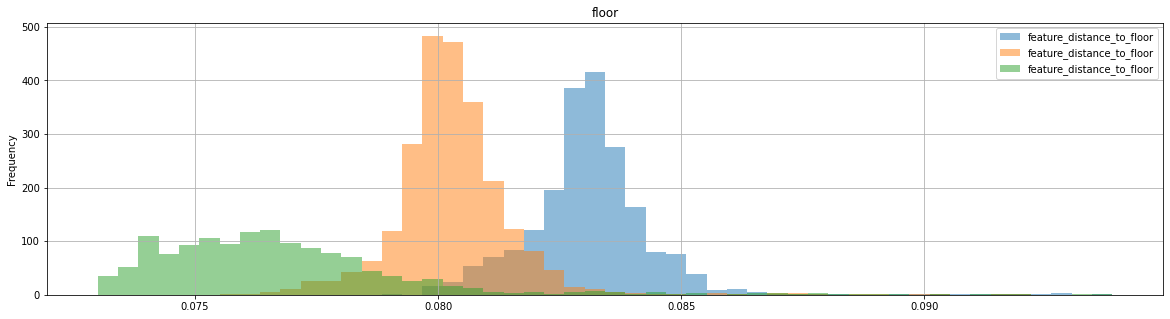

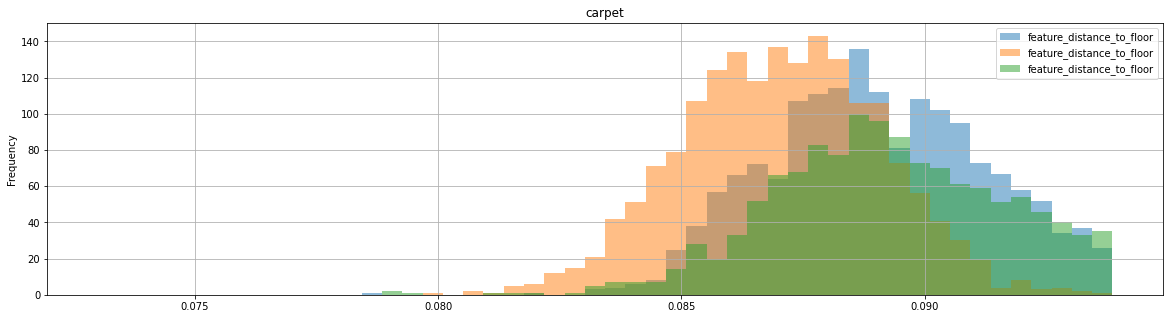

In [4]:
plot_feature_by_file_number(df, 'feature_distance_to_floor', 50)

Lets look at the second feature - the variance of the reflected energy.

As previously discussed, this feature characterizes the amount of reflected energy back towards the sensor.
The hypothesis is that the carpets more uneven surface will cause more energy to be reflected back to the sensor, compared to a more smooth surface, such as a hard floor.

As can be seen in the two histograms below, this seems to be just the case - the carpet has a wider distribution and greater values, while the floor has a narrower distribution with smaller values.

The distributions are somewhat overlapping.
Hence, this feature on its own could cause a greater rate of false positives.
However, as will be shown in a later segment, combining the two features yields a high classification accuracy rate.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


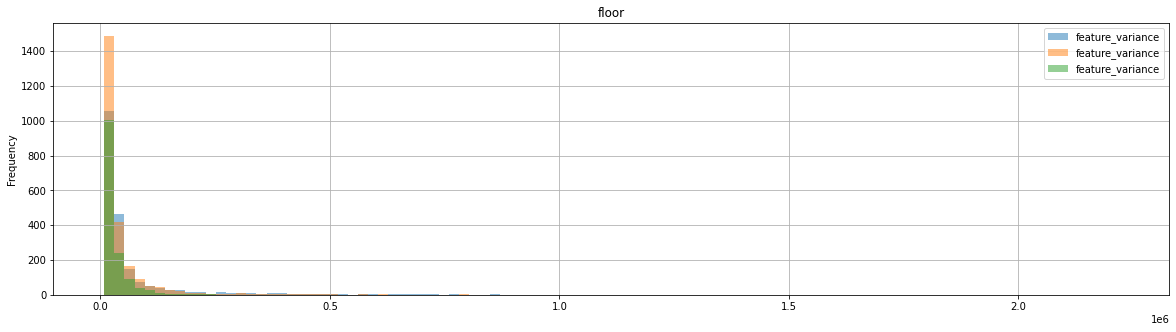

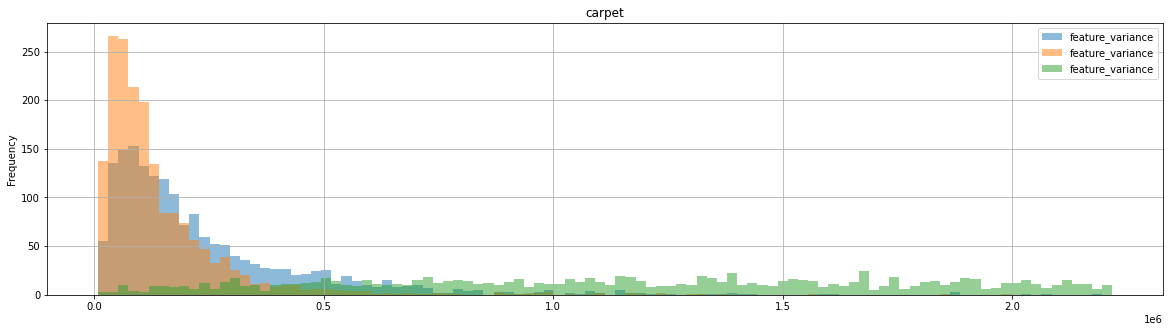

In [5]:
plot_feature_by_file_number(df, 'feature_variance', 100)

Now that our features are extracted, prepared and examined, it is time to move over to the model training part.
The first step is to divide the data into a training and a test set. We you a 70/30 split for the training and the test set.
Before splitting the set, the labels are onehot encoded, representing the sting labels with integers, allowing for numerical representation.

In [6]:
features = ['feature_distance_to_floor', 'feature_variance']

X = np.array(df[features], dtype='float32')
y = np.array(df['labels']).reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y)
y = enc.transform(y).toarray()
print('Classes : ',enc.categories_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

Classes :  [array(['carpet', 'floor'], dtype=object)]


Next, we defined the classification model. 

As previously mentioned, a neural network with three densely connected layers is selected.
The reason for selecting a relatively simple model(few layers with a modest number of nodes) is that the we only have two features and their distributions are fairly well separated for the two classes.

We also use some standard techniques such as data normalization and dropout to improve the performance and robustness.

In [7]:
# setup and compile model
normalization_layer = layers.Normalization(axis=-1)
normalization_layer.adapt(X)

inputs = tf.keras.Input(shape=(len(features)))

x = normalization_layer(inputs)
x = layers.Dense(units=10, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=5, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(units=y.shape[1], activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',    
    metrics=['accuracy'], 
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12    

Here, we train the model and print the result for each epoch.

We usually achieve results in the range of 96-98% accuracy on the test set.
Feel free to modify the model and see if you can achieve better results.
Keras offers a wide variety of models and layers.

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=10,
    epochs=20,
)

Epoch 1/20
769/769 [==============================] - 1s 1ms/step - loss: 0.3150 - accuracy: 0.8867 - val_loss: 0.1343 - val_accuracy: 0.9603
Epoch 2/20
769/769 [==============================] - 1s 656us/step - loss: 0.1813 - accuracy: 0.9485 - val_loss: 0.1280 - val_accuracy: 0.9588
Epoch 3/20
769/769 [==============================] - 1s 661us/step - loss: 0.1680 - accuracy: 0.9538 - val_loss: 0.1281 - val_accuracy: 0.9581
Epoch 4/20
769/769 [==============================] - 0s 643us/step - loss: 0.1508 - accuracy: 0.9563 - val_loss: 0.1274 - val_accuracy: 0.9594
Epoch 5/20
769/769 [==============================] - 0s 646us/step - loss: 0.1572 - accuracy: 0.9546 - val_loss: 0.1275 - val_accuracy: 0.9597
Epoch 6/20
769/769 [==============================] - 0s 641us/step - loss: 0.1564 - accuracy: 0.9545 - val_loss: 0.1266 - val_accuracy: 0.9594
Epoch 7/20
769/769 [==============================] - 1s 672us/step - loss: 0.1498 - accuracy: 0.9566 - val_loss: 0.1269 - val_accuracy: 0

The result of the training is plotted vs each epoch to illustrate the progression of the metrics between each iteration.

As can be seen, the model achieves a low cost function value in just a few iterations, indicating that the model is fitted to the data effectively.

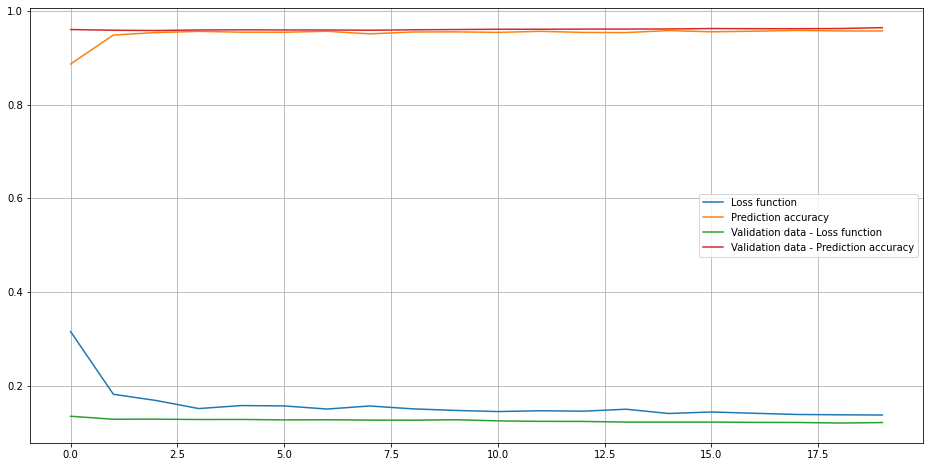

In [9]:
# plot result
history_df = history.history

fig = plt.figure(figsize=(16,8))

plt.plot(history_df['loss'],label='Loss function')
plt.plot(history_df['accuracy'],label='Prediction accuracy')
plt.plot(history_df['val_loss'],label='Validation data - Loss function')
plt.plot(history_df['val_accuracy'],label='Validation data - Prediction accuracy')
plt.grid(True)

plt.legend()

The code snippet below calculates and prints the confusion matrix. 

As can be seen, the false positive rate is high and the false positive rate is close to equally distributed between the two classes.

In [10]:
y_pred = model.predict(X_test)
print('Classes : ',enc.categories_)
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

Classes :  [array(['carpet', 'floor'], dtype=object)]


array([[1444,   64],
       [  54, 1735]], dtype=int64)

Lastly, the model is saved. After running this code, a folder named *model* will show up in you working directory.
This folder contains the trained model an meta data used by the script *realtime_deployment.py*.
Note, if you would like to run this example in realtime on you own, it is very important that the sensor installation closely matches the one we used when collecting data.
If this is not possible or practical, we recommend you to run data collection with your own sensor installation and then rerun this notebook to produce a model that represents your sensor installation and data.

In [11]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets
